# Base ResNet-50 Evaluation

In [49]:
# %pip install nbformat

In [ ]:
# %run data_preprocessing.ipynb

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU with 55GB of memory
Train image count: 9469
Validation image count: 1962
Test image count: 1963
Training ResNet-50 base model...

Freezing the ResNet50 backbone...
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 811ms/step - accuracy: 0.8720 - loss: 0.7931 - top_5_accuracy: 0.9592 - val_accuracy: 0.9827 - val_loss: 0.0866 - val_top_5_accuracy: 0.9985
Unfreezing top layers of the backbone for fine-tuning...
Fine tuning with lower learning rate


/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 410 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [1]:
import os
import sys
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Hide warning logs from tensorflow
tf.get_logger().setLevel("ERROR")

In [2]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 300
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 5
tf.random.set_seed(5)
dataset_dir = "../datasets"

# Change dataset_dir when run in google colab 
if 'google.colab' in sys.modules:
    from google.colab import drive

    drive.mount('/content/drive')
    dataset_dir = "/content/drive/Othercomputers/Big Mac/datasets"
    BATCH_SIZE = 430

physical_gpus = tf.config.list_physical_devices('GPU')
print("Using available GPUs: ", physical_gpus)

tf.keras.mixed_precision.set_global_policy('float32')

Using available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load ImageNet2012 dataset
def prepare_input_data(input):
    image = tf.cast(input['image'], tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = input['label']
    return image, label

def make_dataset(ds):
    return (
        ds.map(prepare_input_data, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )


(train, validation, test), info = tfds.load(
    'imagenet2012_subset/10pct',
    split=['train', 'validation[:50%]', 'validation[50%:]'],
    shuffle_files=False,
    with_info=True,
    data_dir=dataset_dir
)

num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

print(f"Train count: {info.splits['train'].num_examples}")
print(f"Validation count: {info.splits['validation[:50%]'].num_examples}")
print(f"Test count: {info.splits['validation[50%:]'].num_examples}")

train_dataset = make_dataset(train)
validation_dataset = make_dataset(validation)
test_dataset = make_dataset(test)

Train count: 128116
Validation count: 25000
Test count: 25000


In [10]:
# Load ResNet50 model

base_model = ResNet50(
    include_top=True,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

# Compile model
base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
    ]
)


In [11]:
# Load adversarial data

def _parse_function(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image_f16 = tf.io.parse_tensor(parsed_features['image'], out_type=tf.float16)
    label = parsed_features['label']
    image_f32 = tf.cast(image_f16, tf.float32)
    image_f32.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return image_f32, label


# Get all test tfrec files
file_paths = glob.glob(f'{dataset_dir}/adversaries/imagenet2012_subset/test-*.tfrec')
print(f"Found {len(file_paths)} TFrecord files")

# Create a TFRecordDataset from the list of file paths
raw_dataset = tf.data.TFRecordDataset(file_paths,  compression_type='GZIP')
adv_test_dataset = raw_dataset.map(_parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 3 TFrecord files


In [12]:
print("Computing base model metrics...\n")

adv_metrics = base_model.evaluate(adv_test_dataset, batch_size=BATCH_SIZE, verbose=1)
train_metrics = base_model.evaluate(train_dataset, batch_size=BATCH_SIZE ,verbose=1)
test_metrics = base_model.evaluate(test_dataset,batch_size=BATCH_SIZE, verbose=1)

Computing base model metrics...

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.6442 - loss: 1.4630 - top_5_accuracy: 0.8775


/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


428/428 ━━━━━━━━━━━━━━━━━━━━ 315s 735ms/step - accuracy: 0.8135 - loss: 0.6860 - top_5_accuracy: 0.9565
84/84 ━━━━━━━━━━━━━━━━━━━━ 64s 753ms/step - accuracy: 0.7047 - loss: 1.2552 - top_5_accuracy: 0.8991


## Baseline ResNet-50 metrics

In [13]:
# Extract and analyze metrics
try:
    metric_names = ['loss', 'accuracy', 'top_5_accuracy']

    # Unpack metrics directly from the evaluation results
    train_loss, train_acc, train_top5 = train_metrics
    test_loss, test_acc, test_top5 = test_metrics
    adv_loss, adv_acc, adv_top5 = adv_metrics

    # --- METRIC CALCULATIONS ---
    # Generalization Gap: Difference between training and test accuracy.
    # A smaller gap indicates better generalization.
    generalization_gap = train_acc - test_acc
    
    # Robustness/Transferability Gap: Difference between accuracy on clean and adversarial data.
    # This measures how well the model's learning transfers to a perturbed data domain.
    robustness_gap = test_acc - adv_acc

except Exception as e:
    print(f"Error processing metrics: {e}")

print("## Model Performance Analysis 📊")
print("---")

print("### Generalization")
print("Measures the model's ability to perform on unseen clean data compared to training data.")
print(f"* Training Accuracy: `{train_acc*100:.2f}%`")
print(f"* Test Accuracy: `{test_acc*100:.2f}%`")
print(f"**Generalization Gap: `{generalization_gap*100:.2f}%`**\n")

print("### Robustness & Transferability")
print("Measures how the model's performance transfers from a clean to an adversarial data distribution.")
print(f"* Clean Data Accuracy: `{test_acc*100:.2f}%`")
print(f"* Adversarial Data Accuracy: `{adv_acc*100:.2f}%`")
print(f"**Robustness (Transferability) Gap: `{robustness_gap*100:.2f}%`**\n")

print("---")
print("### Detailed Test Metrics (On Clean Data)")
print(f"Top-1 Accuracy: `{test_acc*100:.2f}%`")
print(f"Top-5 Accuracy: `{test_top5*100:.2f}%`")
print(f"Loss: `{test_loss:.3f}`")

## Model Performance Analysis 📊
---
### Generalization
Measures the model's ability to perform on unseen clean data compared to training data.
* Training Accuracy: `81.35%`
* Test Accuracy: `70.47%`
**Generalization Gap: `10.88%`**

### Robustness & Transferability
Measures how the model's performance transfers from a clean to an adversarial data distribution.
* Clean Data Accuracy: `70.47%`
* Adversarial Data Accuracy: `64.42%`
**Robustness (Transferability) Gap: `6.05%`**

---
### Detailed Test Metrics (On Clean Data)
Top-1 Accuracy: `70.47%`
Top-5 Accuracy: `89.91%`
Loss: `1.255`


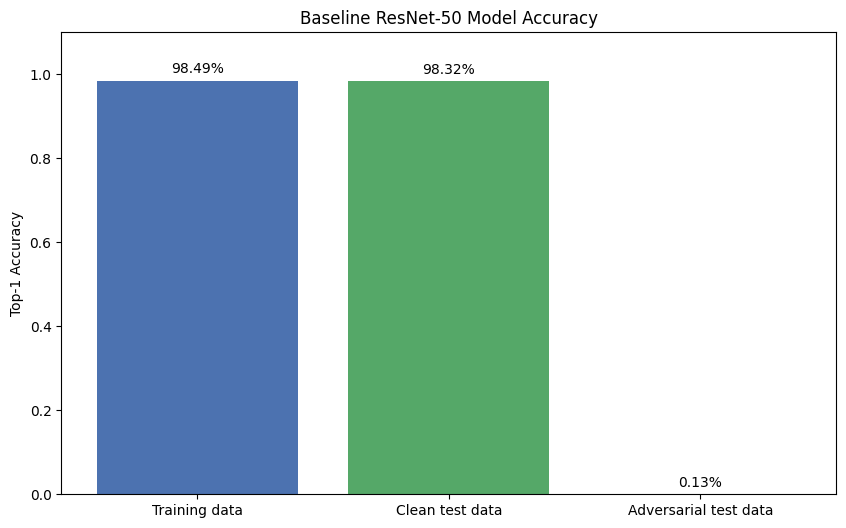

In [59]:
# Final Accuracy Comparison (Train, Test, Adversarial)
accuracies = [train_acc, test_acc, adv_acc]
labels = ['Training data', 'Clean test data', 'Adversarial test data']
colors = ['#4c72b0', '#55a868', '#c44e52']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=colors)

plt.ylabel('Top-1 Accuracy')
plt.title('Baseline ResNet-50 Model Accuracy')
plt.ylim(0, 1.1) # Set y-axis limit to 105% for better visualization

# Add accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval*100:.2f}%', ha='center', va='bottom')

plt.show()

In [60]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# 1. Get true labels and model predictions
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_proba = base_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# 2. Calculate Precision, Recall, F1-Score
# Note: In multi-class classification, these are often averaged.
# 'macro' calculates metrics for each label, and finds their unweighted mean.
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)


# 3. Calculate AUC
# For multi-class, you need to specify how to average.
# 'ovr' (One-vs-Rest) is a common strategy.
auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
print(f"Macro-Averaged AUC (One-vs-Rest): {auc_score:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       193
           1       1.00      1.00      1.00       197
           2       0.98      0.98      0.98       194
           3       0.96      0.97      0.96       186
           4       1.00      0.99      0.99       221
           5       0.98      0.98      0.98       187
           6       0.96      1.00      0.98       185
           7       0.99      0.95      0.97       206
           8       1.00      0.99      0.99       209
           9       0.96      0.99      0.97       185

    accuracy                           0.98      1963
   macro avg       0.98      0.98      0.98      1963
weighted avg       0.98      0.98      0.98      1963

Macro-Averaged AUC (One-vs-Rest): 0.9997


## Detailed Manual Evaluation & Confusion Matrix
Gathering predictions from the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step
Done.

--- Overall Performance Metrics ---
Overall Precision: 0.9828
Overall Recall:    0.9834
Overall F1-Score:  0.9829
Macro-Averaged AUC (One-vs-Rest): 0.9997

--- Confusion Matrix ---


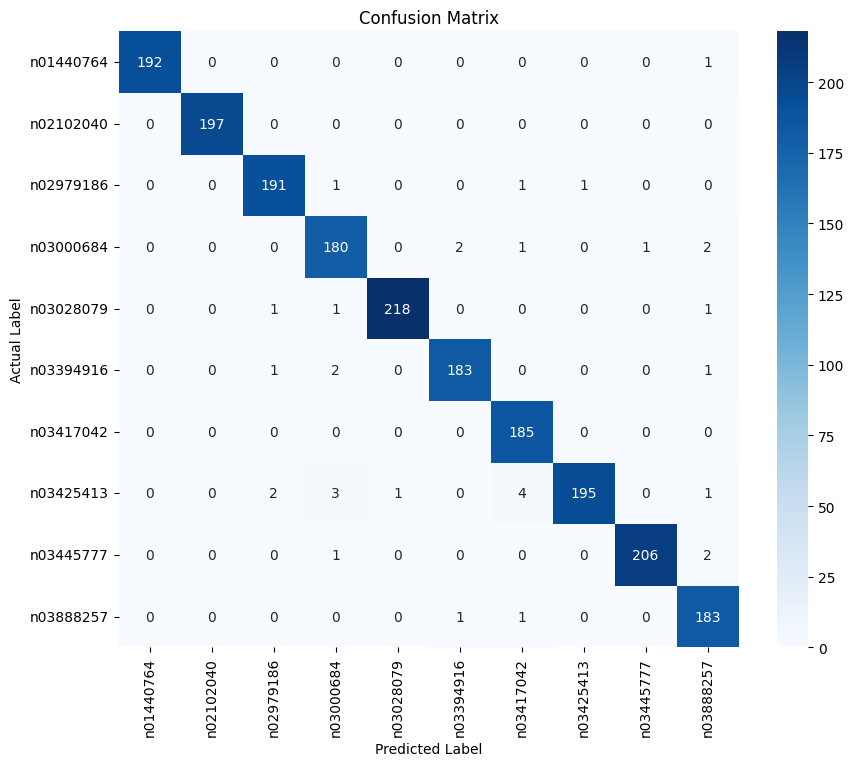

In [61]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("## Detailed Manual Evaluation & Confusion Matrix")

# 1. Get true labels and model predictions from the test dataset
# This can take a moment as it iterates through the entire test set.
print("Gathering predictions from the test set...")
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_proba = base_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
print("Done.")

# --- Overall Performance Metrics ---
print("\n--- Overall Performance Metrics ---")
# Generate the report as a dictionary
report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
# Extract the macro average scores, which give equal weight to each class
macro_avg = report_dict['macro avg']
print(f"Overall Precision: {macro_avg['precision']:.4f}")
print(f"Overall Recall:    {macro_avg['recall']:.4f}")
print(f"Overall F1-Score:  {macro_avg['f1-score']:.4f}")

# --- AUC Calculation ---
auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
print(f"Macro-Averaged AUC (One-vs-Rest): {auc_score:.4f}")

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
# Get class names from the dataset info object
class_names = info.features['label'].names
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Detailed Manual Evaluation & Confusion Matrix
Gathering predictions from the clean test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 587ms/step
Done.

--- Overall Performance Metrics ---
Overall Precision: 0.9828
Overall Recall:    0.9834
Overall F1-Score:  0.9829
Macro-Averaged AUC (One-vs-Rest): 0.9997

--- Confusion Matrix (Clean Test Data) ---


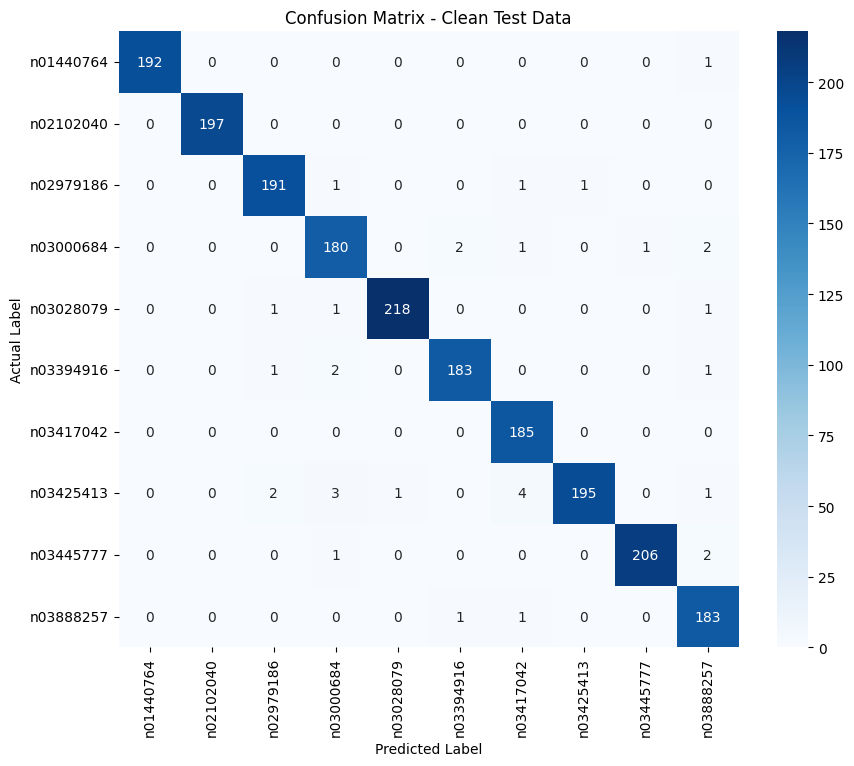


## Adversarial Test Data Evaluation ##

Gathering predictions from the adversarial test set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 615ms/step
Done.
Adversarial Precision: 0.0000
Adversarial Recall:    0.0010
Adversarial F1-Score:  0.0000


/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/stanleyokwii/Documents/Birkbeck/Msc Project/msc-project-source-code-files-24-25-Stanley-Okwii/.venv/lib/python3.12/site-packages/skl

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

: 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("## Detailed Manual Evaluation & Confusion Matrix")

# --- Clean Test Dataset ---
print("Gathering predictions from the clean test set...")
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_proba = base_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
print("Done.")

# --- Overall Performance Metrics ---
print("\n--- Overall Performance Metrics ---")
report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
macro_avg = report_dict['macro avg']
print(f"Overall Precision: {macro_avg['precision']:.4f}")
print(f"Overall Recall:    {macro_avg['recall']:.4f}")
print(f"Overall F1-Score:  {macro_avg['f1-score']:.4f}")

# --- AUC Calculation ---
auc_score = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
print(f"Macro-Averaged AUC (One-vs-Rest): {auc_score:.4f}")

# --- Confusion Matrix (Clean Data) ---
print("\n--- Confusion Matrix (Clean Test Data) ---")
class_names = info.features['label'].names
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Clean Test Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# =====================================================
# --- Evaluation on Adversarial Test Dataset ---
# =====================================================
print("\n## Adversarial Test Data Evaluation ##\n")

print("Gathering predictions from the adversarial test set...")
y_true_adv = np.concatenate([y for x, y in adv_test_dataset], axis=0)
y_pred_proba_adv = base_model.predict(adv_test_dataset)
y_pred_classes_adv = np.argmax(y_pred_proba_adv, axis=1)
print("Done.")

# --- Overall Performance Metrics (Adversarial) ---
report_dict_adv = classification_report(y_true_adv, y_pred_classes_adv, output_dict=True)
macro_avg_adv = report_dict_adv['macro avg']
print(f"Adversarial Precision: {macro_avg_adv['precision']:.4f}")
print(f"Adversarial Recall:    {macro_avg_adv['recall']:.4f}")
print(f"Adversarial F1-Score:  {macro_avg_adv['f1-score']:.4f}")

# --- AUC Calculation (Adversarial) ---
auc_score_adv = roc_auc_score(y_true_adv, y_pred_proba_adv, multi_class='ovr', average='macro')
print(f"Adversarial Macro-Averaged AUC (One-vs-Rest): {auc_score_adv:.4f}")

# --- Confusion Matrix (Adversarial Data) ---
print("\n--- Confusion Matrix (Adversarial Test Data) ---")
cm_adv = confusion_matrix(y_true_adv, y_pred_classes_adv)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Adversarial Test Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()